                     p (mbar)  T (degC)  ...  max. wv (m/s)  wd (deg)
Date Time                                ...                         
01.01.2009 00:10:00    996.52     -8.02  ...           1.75     152.3
01.01.2009 00:20:00    996.57     -8.41  ...           1.50     136.1
01.01.2009 00:30:00    996.53     -8.51  ...           0.63     171.6
01.01.2009 00:40:00    996.51     -8.31  ...           0.50     198.0
01.01.2009 00:50:00    996.51     -8.27  ...           0.63     214.3

[5 rows x 14 columns]
   var1(t-1)  var2(t-1)  var3(t-1)  ...  var12(t)  var13(t)  var14(t)
1   0.835550   0.254629   0.248031  ...  0.049214  0.063830  0.378056
2   0.836054   0.248004   0.241495  ...  0.012987  0.026809  0.476667
3   0.835651   0.246305   0.239819  ...  0.023240  0.021277  0.550000
4   0.835449   0.249703   0.243338  ...  0.021873  0.026809  0.595278
5   0.835449   0.250382   0.243841  ...  0.014354  0.026809  0.535278

[5 rows x 28 columns]
(150000, 1, 27) (150000,) (95197, 1, 27) (95

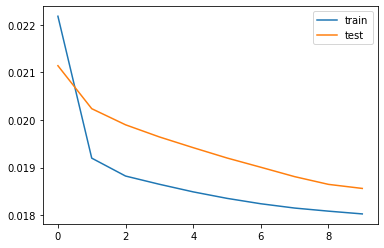

In [13]:
import tensorflow as tf

import matplotlib.pyplot as plt
import pandas as pd
from keras import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.losses import mean_squared_error
from matplotlib import pyplot
from numpy import concatenate, sqrt
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler


def parse(x):
    return pd.datetime.strptime(x, '%M %D %Y %H')

# convert series to supervised learning


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if isinstance(data, list) else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# 读数据
dataset = read_csv('jena_climate_2009_2016.csv', header=0, index_col=0)
values = dataset.values
print(dataset.head())

values = values.astype('float32')

# 标准化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 1, 1)

print(reframed.head())

# split into train and test sets
values = reframed.values
n_train_hours = 150000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=5,
                 strides=1, padding="causal",
                 activation="relu"))
model.add(
    LSTM(
        50,
        input_shape=(
            train_X.shape[1],
            train_X.shape[2]),
        return_sequences=True))
model.add(Dense(25, activation="relu"))
model.add(Dense(1))


model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer='adam',
    metrics=["mae"])
# fit network
history = model.fit(
    train_X,
    train_y,
    epochs=10,
    batch_size=36,
    validation_data=(
        test_X,
        test_y),
    verbose=2,
    shuffle=False)


# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
